<a href="https://colab.research.google.com/github/mchirico/COVID-19/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID-19**

Note:  You need to make a copy of this note book, if you want to run it yourself
by clicking on "File/Save a copy in Drive"



Sharable link:
https://colab.research.google.com/drive/1RZXskxLFGTMcw7Q88VwIWk7vSceGbIkf







Data From: 
[JHU CSSE](https://github.com/CSSEGISandData/COVID-19)



In [0]:
import requests
import pandas as pd
import numpy as np 
from datetime import datetime



import warnings
warnings.filterwarnings("ignore")

try:
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive
  import torch
except:
  print("Will try to install software")
  # Lines below .... Only need to be run once at the top of the notebook.
  !pip install -q matplotlib-venn
  !pip install -q keras
  # #   https://pypi.python.org/pypi/pydot
  !apt-get -qq install -y graphviz && pip install -q pydot
  !apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
  !pip install -U -q PyDrive
  !pip install --upgrade -q gspread
  
  !pip install torchvision
  
  import seaborn as sns
  import matplotlib.pyplot as plt
  import matplotlib.dates as mdates
  sns.set(style="white", color_codes=True)
  from matplotlib_venn import venn2
  import keras
  import pydot
  import libarchive





## Reading in the data..

#### Read in Confirmed Cases

In [51]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
d=pd.read_csv(url)
d.head()

# US counted twice: 1) County 2) State
c = d[(d['Country/Region']=='US') & (d['Province/State'].str.contains(','))]
cols = d.columns[0:4].tolist() + d.columns[-10::].tolist()

t = c[cols]
t[t['Province/State'].str.contains(', PA')]
#t.diff(axis=1)


,Province/State,Country/Region,Lat,Long,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
234,"Monroe, PA",US,41.0458,-75.2479,0,0,0,0,0,0,0,0,1,2
235,"Philadelphia, PA",US,39.9526,-75.1652,0,0,0,0,0,0,0,0,1,1
284,"Montgomery County, PA",US,40.2290,-75.3879,0,0,0,0,0,0,4,5,8,9
307,"Delaware County, PA",US,39.9078,-75.3879,0,0,0,0,1,1,1,1,1,1
315,"Wayne County, PA",US,41.6739,-75.2479,0,0,0,0,1,1,1,1,1,1
378,"Bucks, PA",US,40.4108,-75.2479,0,0,0,0,0,0,0,0,0,1


In [7]:
# Deaths
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
dt=pd.read_csv(url)
dt.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,2,4,4,5,6,6,6,6,6,6,6,6,10,10,15
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Recovered
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
dr=pd.read_csv(url)
dr.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,5,5,5,5,5,5,5,5,5,5,5,10,10,10,10,10,12,12,12,14,15,15,15,15,17,17,21,21,22,22,22,28,28,28,31,31,31,31,31,31,31,31,33,34
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,9,9,9,9,12,12,12,13,18,18,22,22,22,22,22,22,22,22,32,32,32,43,43,43,46,76,76,76,101,118
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,9,15,15,17,18,18,24,29,34,34,37,37,51,51,53,62,62,62,72,72,78,78,78,78,78,78,78,78,78,96
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,3,7,7,7,13,15,15,15,15,15,18,18,18,18,18,18,18,18,22,22,22,22,23,24,24,24,26


In [25]:
# Confirmed
m=pd.melt(d, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
m.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
m['timeStamp'] = m['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
m.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2
1,NaN,Japan,36.0000,138.0000,2020-01-22,2
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


In [10]:
# deaths
mt=pd.melt(dt, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
mt.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
mt['timeStamp'] = mt['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
mt.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


In [26]:
# Recovered
mr=pd.melt(dr, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_vars=d.columns[4::])
mr.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'timeStamp', 'value']
mr['timeStamp'] = mr['timeStamp'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
mr.head()

,Province/State,Country/Region,Lat,Long,timeStamp,value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


## Summary Tables

In [27]:
n=pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns=pd.pivot_table(m, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
ns = ns.diff(axis=1)
ns=ns.reset_index()

ns[ns['Country/Region']=='US'].head()
t = pd.pivot_table(m, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
t = t.reset_index()
t[t['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00
109,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,1665,2384


In [34]:
# We both 'Province/State', 'Country/Region'
# Careful, data counted twice
n=pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
nsc=pd.pivot_table(m, values='value', index=['Province/State','Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
nsc = nsc.diff(axis=1)
nsc=nsc.reset_index()

nsc[nsc['Country/Region']=='US'].head()
t = pd.pivot_table(m, values='value', index=['Province/State', 'Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
t = t.reset_index()
t[t['Country/Region']=='US']

nsc

timeStamp,Province/State,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00
0,"Adams, IN",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,"Alachua, FL",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,"Alameda County, CA",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0
3,Alaska,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alberta,Canada,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,Wyoming,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294,Xinjiang,China,NaN,2.0,0.0,1.0,1.0,1.0,5.0,3.0,1.0,3.0,1.0,3.0,3.0,5.0,3.0,4.0,3.0,3.0,3.0,4.0,6.0,4.0,4.0,2.0,5.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295,"Yolo County, CA",US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
296,Yunnan,China,NaN,1.0,3.0,6.0,5.0,10.0,18.0,11.0,15.0,13.0,10.0,12.0,12.0,5.0,6.0,5.0,5.0,0.0,3.0,8.0,4.0,1.0,2.0,6.0,6.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Deaths
nt=pd.pivot_table(mt, values='value', index=['Province/State', 'Country/Region', 'Lat', 'Long'],
                    columns=['timeStamp'], aggfunc=np.sum)
nst=pd.pivot_table(mt, values='value', index=['Country/Region'],
                    columns=['timeStamp'], aggfunc=np.sum)
nst = nst.diff(axis=1)
nst=nst.reset_index()
nst.columns
nst[nst[nst.columns[44]]>0]

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00
24,China,NaN,1.0,8.0,16.0,14.0,26.0,49.0,2.0,38.0,42.0,46.0,102.0,64.0,66.0,72.0,70.0,85.0,87.0,100.0,107.0,100.0,5.0,252.0,152.0,142.0,103.0,98.0,139.0,113.0,122.0,0.0,205.0,2.0,150.0,70.0,52.0,29.0,44.0,47.0,35.0,42.0,33.0,36.0,32.0,29.0,28.0,28.0,23.0,16.0,22.0
39,France,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,2.0,8.0,0.0,14.0,15.0
50,Iran,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,3.0,4.0,4.0,3.0,7.0,8.0,9.0,11.0,12.0,11.0,15.0,15.0,17.0,21.0,49.0,43.0,54.0,63.0
54,Italy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,3.0,2.0,5.0,4.0,8.0,5.0,18.0,27.0,28.0,41.0,49.0,36.0,133.0,97.0,168.0,196.0
100,Spain,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,5.0,7.0,11.0,7.0,19.0
103,Switzerland,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
109,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,34.0,12.0
112,United Kingdom,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0


In [14]:

ns.head()

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00
0,Afghanistan,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,2.0
1,Albania,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0
2,Algeria,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,0.0,5.0,0.0,2.0,1.0,0.0,0.0
3,Andorra,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Argentina,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,0.0,5.0,2.0


In [15]:
ns[ns['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00
109,US,NaN,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,36.0,0.0,6.0,1.0,2.0,8.0,6.0,24.0,20.0,31.0,68.0,45.0,140.0,116.0,65.0,1082.0,719.0


In [35]:
nm=pd.melt(nsc, id_vars=['Province/State','Country/Region'], value_vars=ns.columns[1::])
nm.head(7)

,Province/State,Country/Region,timeStamp,value
0,"Adams, IN",US,2020-01-22,NaN
1,"Alachua, FL",US,2020-01-22,NaN
2,"Alameda County, CA",US,2020-01-22,NaN
3,Alaska,US,2020-01-22,NaN
4,Alberta,Canada,2020-01-22,NaN
5,Anhui,China,2020-01-22,NaN
6,"Anoka, MN",US,2020-01-22,NaN


In [36]:
nm[nm['Country/Region']=='US']

,Province/State,Country/Region,timeStamp,value
0,"Adams, IN",US,2020-01-22,NaN
1,"Alachua, FL",US,2020-01-22,NaN
2,"Alameda County, CA",US,2020-01-22,NaN
3,Alaska,US,2020-01-22,NaN
6,"Anoka, MN",US,2020-01-22,NaN
...,...,...,...,...
14892,"Williamson County, TN",US,2020-03-11,4.0
14893,Wisconsin,US,2020-03-11,3.0
14894,"Worcester, MA",US,2020-03-11,0.0
14895,Wyoming,US,2020-03-11,0.0


In [41]:
t = nm[(nm['Country/Region']=='US') & (nm['Province/State'].str.contains(','))]
t[t.columns[1::]]

,Country/Region,timeStamp,value
0,US,2020-01-22,NaN
1,US,2020-01-22,NaN
2,US,2020-01-22,NaN
6,US,2020-01-22,NaN
7,US,2020-01-22,NaN
...,...,...,...
14889,US,2020-03-11,23.0
14891,US,2020-03-11,1.0
14892,US,2020-03-11,4.0
14894,US,2020-03-11,0.0


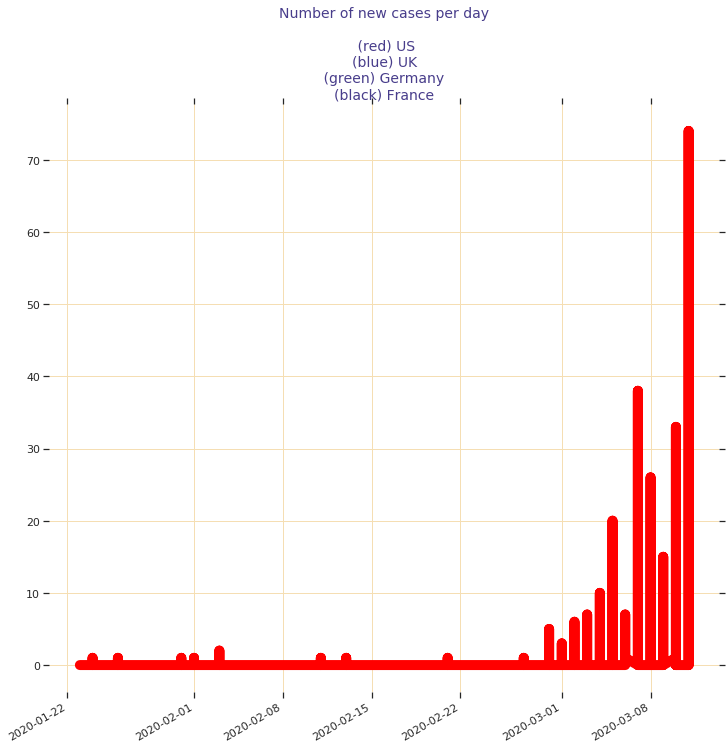

In [44]:

t = nm[(nm['Country/Region']=='US') & (nm['Province/State'].str.contains(','))]
# Adjust for extra col
t = t[t.columns[1::]]
t2=nm[nm['Country/Region']=='UK']
t3=nm[nm['Country/Region']=='Germany']
t4=nm[nm['Country/Region']=='France']



from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12,12))



ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 


ax.plot(t['timeStamp'],t['value'],color = 'red',linewidth=10)
#ax.plot(t2['timeStamp'],t2['value'],color = 'blue')
#ax.plot(t3['timeStamp'],t3['value'],color = 'green')
#ax.plot(t3['timeStamp'],t4['value'],color = 'black')


ax.set_title("""Number of new cases per day
\n (red) US\n(blue) UK\n (green) Germany \n(black) France""", 
             fontsize=14, color='darkslateblue')


ax.grid(b=True, which='major', color='wheat', linestyle='-')


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")  


 

fig.autofmt_xdate()
plt.show()

In [19]:

mySet = list(nm[nm['value'] > 50]['Country/Region'].drop_duplicates())

t = nm[nm['Country/Region'].isin(mySet)]
p = pd.pivot_table(t, values='value', index=['timeStamp'], columns=['Country/Region'], aggfunc=np.sum)


# 1 week intervals
pp = p.resample('7d').apply(np.sum).reset_index()
pp.head(400)

Country/Region,timeStamp,Austria,Bahrain,Belgium,China,Cruise Ship,Denmark,France,Germany,Iran,Italy,Japan,"Korea, South",Netherlands,Norway,Qatar,Spain,Sweden,Switzerland,US,United Kingdom
0,2020-01-22,0.0,0.0,0.0,4961.0,0.0,0.0,4.0,4.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
1,2020-01-29,0.0,0.0,1.0,18198.0,0.0,0.0,2.0,8.0,0.0,2.0,15.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,2.0
2,2020-02-05,0.0,0.0,0.0,20679.0,135.0,0.0,5.0,4.0,0.0,1.0,4.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0
3,2020-02-12,0.0,0.0,0.0,29825.0,407.0,0.0,1.0,0.0,0.0,0.0,48.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,2020-02-19,2.0,23.0,0.0,3543.0,149.0,0.0,2.0,1.0,95.0,319.0,96.0,946.0,0.0,0.0,0.0,4.0,0.0,1.0,38.0,4.0
5,2020-02-26,19.0,26.0,12.0,2507.0,15.0,6.0,190.0,179.0,2241.0,2180.0,123.0,4209.0,24.0,32.0,7.0,159.0,20.0,55.0,67.0,38.0
6,2020-03-04,161.0,61.0,254.0,626.0,-10.0,258.0,1583.0,1261.0,5706.0,7647.0,288.0,2327.0,358.0,368.0,17.0,1530.0,334.0,435.0,1547.0,333.0
7,2020-03-11,64.0,85.0,47.0,34.0,0.0,180.0,497.0,451.0,958.0,2313.0,58.0,242.0,121.0,198.0,238.0,582.0,145.0,161.0,719.0,75.0


In [20]:
# Deaths
nmt=pd.melt(nst, id_vars=['Country/Region'], value_vars=ns.columns[1::])



mySet = list(nmt[nmt['value'] > 1]['Country/Region'].drop_duplicates())

t = nmt[nmt['Country/Region'].isin(mySet)]
p = pd.pivot_table(t, values='value', index=['timeStamp'], columns=['Country/Region'], aggfunc=np.sum)


# 1 week intervals
pp = p.resample('7d').apply(np.sum).reset_index()
pp.head(400)

Country/Region,timeStamp,Belgium,China,Cruise Ship,France,Germany,Iran,Iraq,Italy,Japan,"Korea, South",Lebanon,Netherlands,Spain,US,United Kingdom
0,2020-01-22,0.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-29,0.0,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-02-05,0.0,621.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-02-12,0.0,891.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-19,0.0,662.0,3.0,0.0,0.0,16.0,0.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
5,2020-02-26,0.0,282.0,3.0,3.0,0.0,61.0,0.0,69.0,5.0,18.0,0.0,0.0,1.0,7.0,0.0
6,2020-03-04,0.0,192.0,0.0,29.0,2.0,214.0,7.0,552.0,4.0,26.0,1.0,4.0,34.0,49.0,6.0
7,2020-03-11,3.0,22.0,1.0,15.0,1.0,63.0,0.0,196.0,5.0,6.0,2.0,1.0,19.0,12.0,2.0


In [21]:
nst[nst['Country/Region']=='US']

timeStamp,Country/Region,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00
109,US,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,1.0,2.0,3.0,4.0,1.0,34.0,12.0
